In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import torch
import torchvision
from torchvision import transforms
# from datasets import load_from_disk
# from transformers import AutoTokenizer

import os
import itertools
import json
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/pbs.2441081.pbsha.ib.sockeye/matplotlib-9slcyc1o because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from spotlight.datasets import *
from spotlight.utils import *
from spotlight.plot_utils import *

setupPlots()

In [8]:
os.environ['DATA_DIR'] = os.environ['TMPDIR']

In [10]:
data_dir = os.environ['DATA_DIR'] 
fairface_dir = os.path.join(data_dir, 'fairface')
imagenet_dir = os.path.join(data_dir, 'imagenet')
xray_dir = os.path.join(data_dir, 'xray')
ml_100k_dir = os.path.join(data_dir, 'movielens/ml-100k')

# FairFace

## Dataset

In [11]:
fairface_val = FairFace(
    fairface_dir,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

In [12]:
fairface_labels = [fairface_val[i][2] for i in range(2000)]

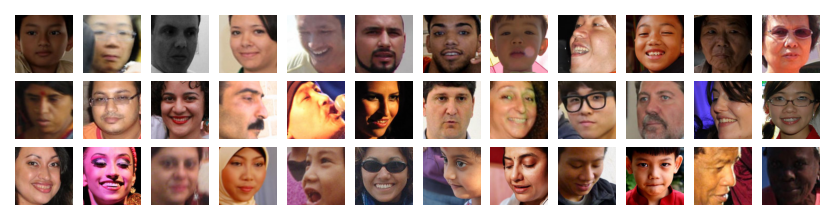

In [21]:
examples = [fairface_val[i] for i in range(18*4)]
images = [example[0] for example in examples]
titles = ['Female' if example[2] else 'Male' for example in examples]
titles = ['' for example in examples]
plotImageGrid((5.5, 1.4), (12, 3), images, titles)
plt.savefig('figures/fairface_val_random.png')

## Model outputs

In [14]:
embeddings, outputs, losses = loadInferenceResults(
    os.path.join(scratch_dir, 'spotlight/inference_results/fairface_val_resnet.pkl'),
)

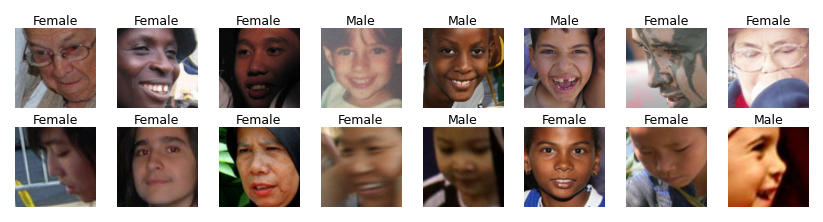

In [22]:
loss_idx = losses.argsort()[::-1]
examples = [fairface_val[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = [('Female' if example[2] else 'Male') + (' (%.3f)' % example_losses[i]) for (i, example) in enumerate(examples)]
titles = [('Female' if example[2] else 'Male') for (i, example) in enumerate(examples)]
plotImageGrid((5.5, 1.4), (8, 2), images, titles)
plt.savefig('figures/fairface_val_loss.png')

## Spotlights

In [23]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadSpotlightResults(f'spotlight_results/fairface_val_resnet_0.02_spherical_{count}.pkl')
    

In [24]:
def plotHighWeightImages(spotlight, figname=None):
    weights = spotlight[0]
    weight_idx = weights.argsort()[::-1]
    examples = [fairface_val[i] for i in weight_idx[:18]]
    example_losses = [losses[i] for i in weight_idx[:18]]
    images = [example[0] for example in examples]
    titles = [('Female' if example[2] else 'Male') for (i, example) in enumerate(examples)]

    plotImageGrid((5.5, 1.4), (8, 2), images, titles, )
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

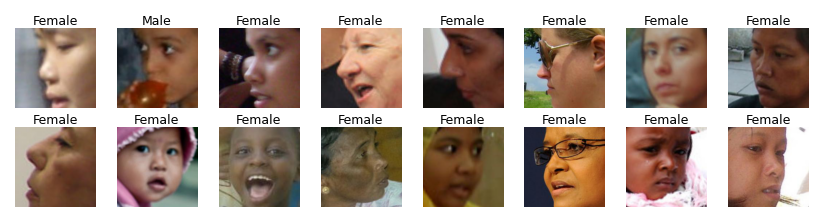

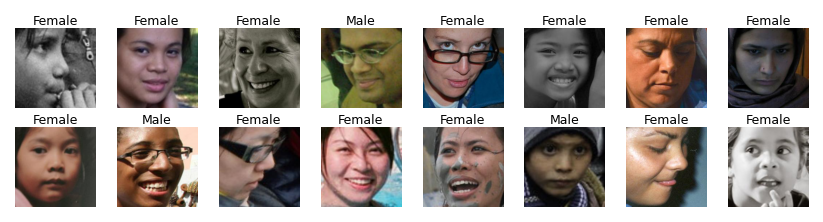

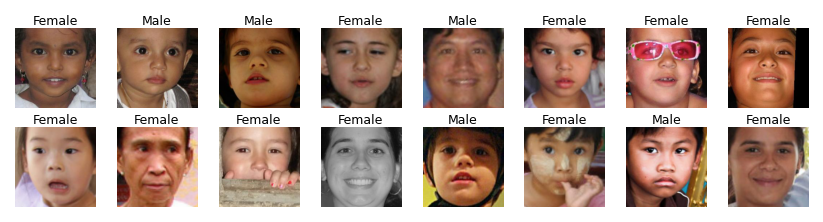

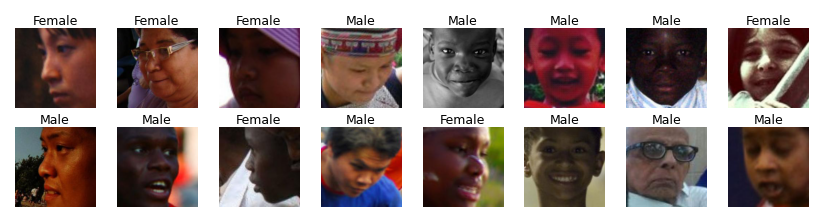

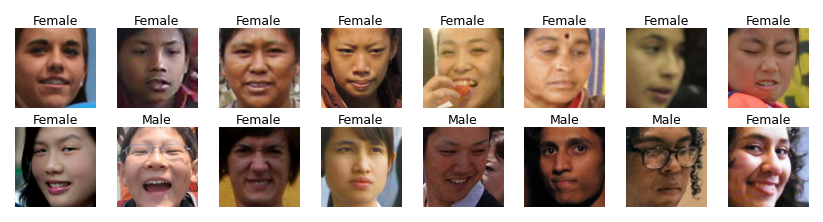

In [239]:
plotHighWeightImages(spotlights[1], 'fairface_val_1.png')
plotHighWeightImages(spotlights[2], 'fairface_val_2.png')
plotHighWeightImages(spotlights[3], 'fairface_val_3.png')
plotHighWeightImages(spotlights[4], 'fairface_val_4.png')
plotHighWeightImages(spotlights[5], 'fairface_val_5.png')

# ImageNet

## Dataset

In [25]:
imagenet = torchvision.datasets.ImageNet(
    root=imagenet_dir, 
    split='val',
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]))

In [26]:
# For image captions, shorten a few long labels 
synset_changes = {
    'leatherback turtle': 'leatherback',
    'African hunting dog': 'hunting dog',
    'Chesapeake Bay retriever': 'Chessie',
    'Bouvier des Flandres': 'Bouvier',
    'Kerry blue terrier': 'blue terrier',
    'American Staffordshire terrier': 'American terrier',
}

In [27]:
with open('spotlight/imagenet_synsets.txt') as f:
    synset_strings = '\n'.join(f.readlines())
synset_lookup = eval(synset_strings)

imagenet_labels = []
for i in range(1000):
    synset_label = synset_lookup[i]['label'].split(',')[0]
    if synset_label in synset_changes:
        synset_label = synset_changes[synset_label]
    imagenet_labels += [synset_label] * 50

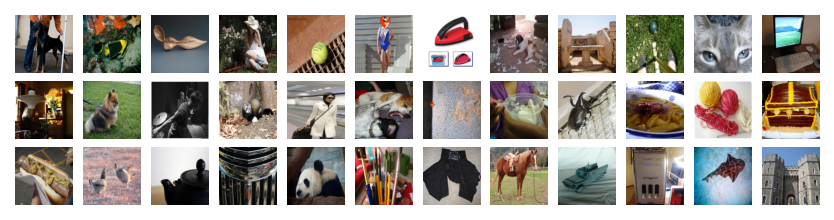

In [29]:
np.random.seed(0)
random_idx = np.random.permutation(len(imagenet))
examples = [imagenet[random_idx[i]] for i in range(100)]
images = [example[0] for example in examples]
titles = ['' for example in examples]
plotImageGrid((5.5, 1.4), (12, 3), images, titles)
plt.savefig('figures/imagenet_val_random.png')

## Model outputs

In [30]:
embeddings, outputs, losses = loadInferenceResults(
    os.path.join(scratch_dir, 'spotlight/inference_results/imagenet_val_resnet.pkl'),
)

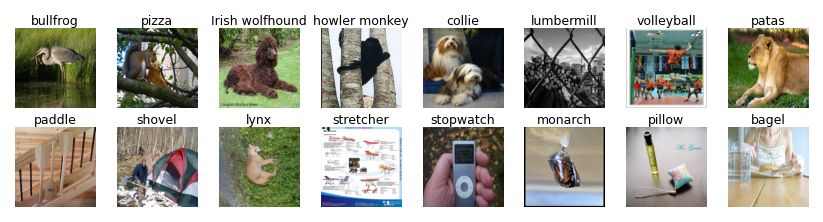

In [32]:
loss_idx = losses.argsort()[::-1]
examples = [imagenet[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = [imagenet_labels[loss_idx[i]] for (i, example) in enumerate(examples)]
plotImageGrid((5.5, 1.4), (8, 2), images, titles)
plt.savefig('figures/imagenet_val_loss.png')

## Spotlights

In [33]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadSpotlightResults(f'spotlight_results/imagenet_val_resnet_0.02_spherical_{count}.pkl')

In [34]:
def plotSpotlightsImagenet(spotlight, figname=None):
    weights = spotlight[0]
    weight_idx = weights.argsort()[::-1]
    examples = [imagenet[i] for i in weight_idx[:100]]
    example_losses = [losses[i] for i in weight_idx[:100]]
    images = [example[0] for example in examples]
    titles = [imagenet_labels[i] for i in weight_idx[:100]]

    plotImageGrid((5.5, 1.4), (8, 2), images, titles, )
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

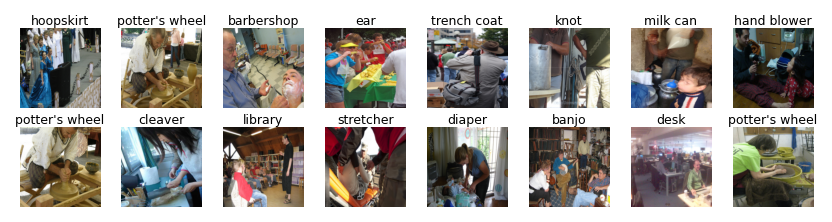

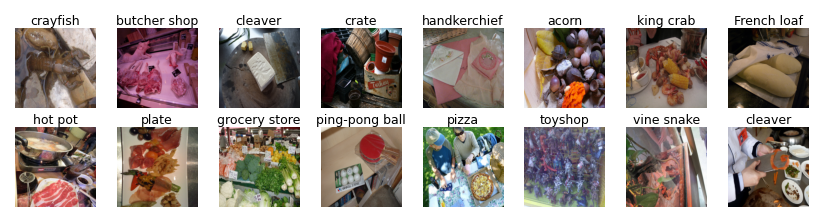

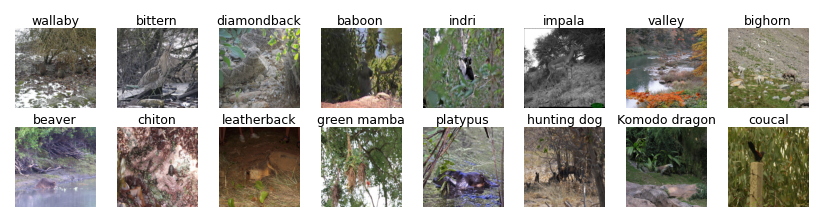

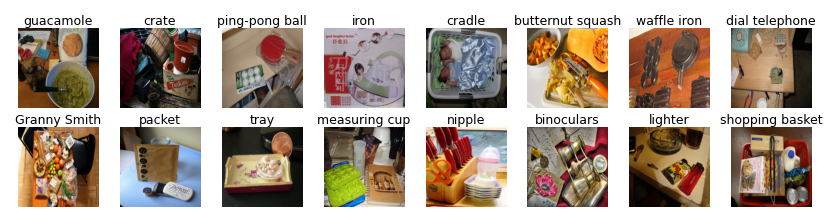

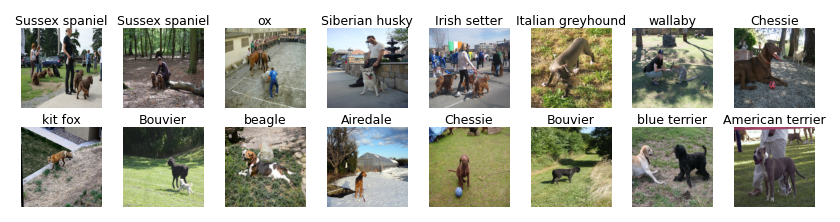

In [35]:
plotSpotlightsImagenet(spotlights[1], 'imagenet_val_1.png')
plotSpotlightsImagenet(spotlights[2], 'imagenet_val_2.png')
plotSpotlightsImagenet(spotlights[3], 'imagenet_val_3.png')
plotSpotlightsImagenet(spotlights[4], 'imagenet_val_4.png')
plotSpotlightsImagenet(spotlights[5], 'imagenet_val_5.png')

# X-ray

## Dataset

In [36]:
xray_train = ChestXRay(
    xray_dir,
    train=True,
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((150,150)),
        transforms.ToTensor(),
    ]))

In [37]:
xray_labels = np.array([xray_train[i][1] for i in range(len(xray_train))])

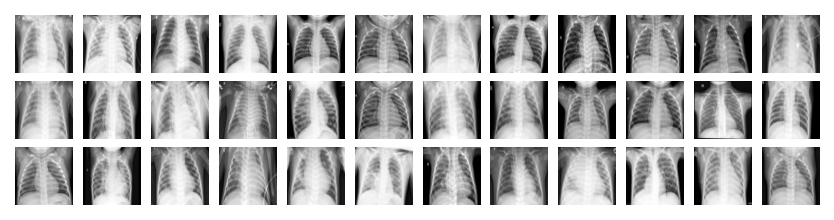

In [38]:
np.random.seed(0)
random_idx = np.random.permutation(len(xray_train))
examples = [xray_train[random_idx[i]] for i in range(100)]
images = [example[0] for example in examples]
# titles = ['Female' if example[2] else 'Male' for example in examples]
titles = ['' for example in examples]
# plotImageGrid((5.5, 1.4), (9, 2), images, titles)
plotImageGrid((5.5, 1.4), (12, 3), images, titles, cmap='gray')
plt.savefig('figures/xray_train_random.png')

## Model outputs

In [41]:
embeddings, outputs, losses = loadInferenceResults('inference_results/xray_train_cnn.pkl')

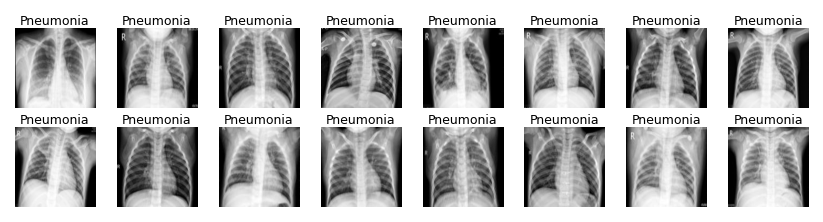

In [42]:
loss_idx = losses.argsort()[::-1]
examples = [xray_train[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = ['Pneumonia' if xray_labels[loss_idx[i]] else 'Normal' for (i, example) in enumerate(examples)]
plotImageGrid((5.5, 1.4), (8, 2), images, titles, cmap='gray')
plt.savefig('figures/xray_train_loss.png')

## Spotlights

In [43]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadSpotlightResults(f'spotlight_results/xray_train_cnn_0.02_spherical_{count}.pkl')

In [44]:
def plotSpotlightsXray(spotlight, figname=None):
    weights = spotlight[0]
    weight_idx = weights.argsort()[::-1]
    examples = [xray_train[i] for i in weight_idx[:100]]
    example_losses = [losses[i] for i in weight_idx[:100]]
    images = [example[0] for example in examples]
    titles = ['Pneumonia' if xray_labels[weight_idx[i]] else 'Normal' for (i, example) in enumerate(examples)]

    plotImageGrid((5.5, 1.4), (8, 2), images, titles, cmap='gray')
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

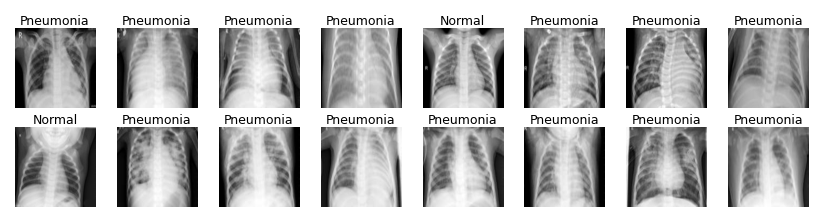

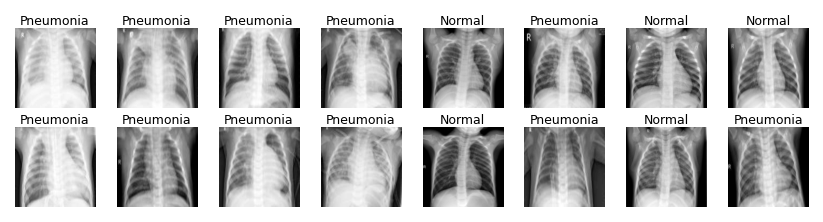

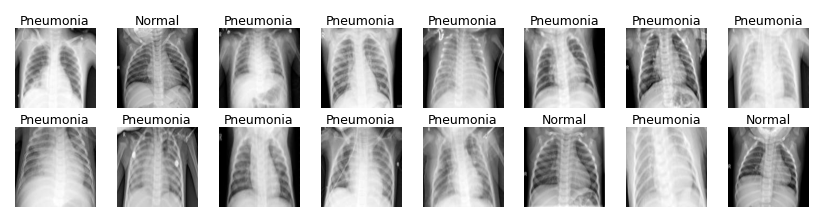

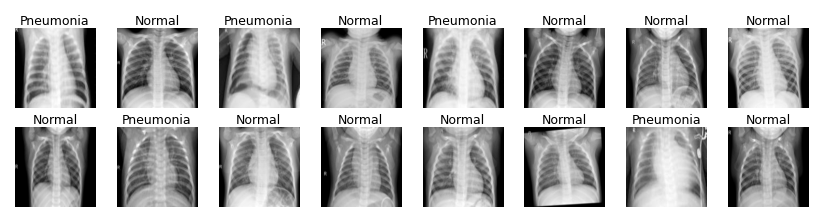

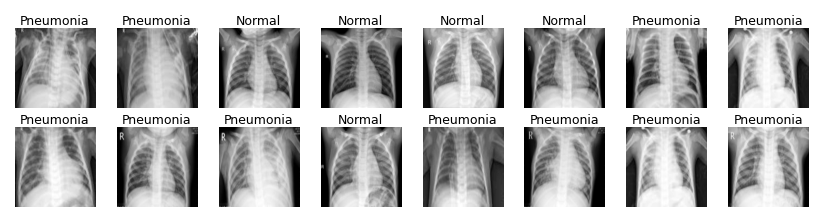

In [45]:
plotSpotlightsXray(spotlights[1], 'xray_train_1.png')
plotSpotlightsXray(spotlights[2], 'xray_train_2.png')
plotSpotlightsXray(spotlights[3], 'xray_train_3.png')
plotSpotlightsXray(spotlights[4], 'xray_train_4.png')
plotSpotlightsXray(spotlights[5], 'xray_train_5.png')

# MovieLens

## Model outputs

In [46]:
embeddings, outputs, losses = loadInferenceResults(
    os.path.join(scratch_dir, 'spotlight/inference_results/movielens_val_deepset.pkl'),
)

## Dataset

In [47]:
def get_genre(row):
    ret = []
    for c in movie_df.columns:
        if row[c]==1:
            ret.append(c)
    return ret[0]


def compressMean(row):
    return '%.1f (%d)' % (row['review_mean'], row['num_reviews'])

In [48]:
df = pd.read_csv(ml_100k_dir + '/u1.test', sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
df['prediction'] = outputs.argmax(axis=1) + 1
df['loss'] = losses
display(df.columns)
df = df.drop('unix_timestamp', axis=1)

user_df = pd.read_csv(
    ml_100k_dir + '/u.user', sep='|', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
).set_index('user_id').drop('zip_code', axis=1)

movie_genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi','Thriller', 'War', 'Western']
movie_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + movie_genres
movie_df = pd.read_csv(ml_100k_dir + '/u.item', sep='|', header=None, names=movie_cols) \
    .set_index('movie_id') \
    .drop(['release_date', 'video_release_date', 'IMDb_URL'], axis=1)
movie_df['genre'] = movie_df.apply(get_genre, axis=1)

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'prediction',
       'loss'],
      dtype='object')

In [50]:
num_reviews = []
avg_reviews = []
stddev_reviews = []
for movie_id in movie_df.index:
    movie_reviews = df[df['movie_id'] == movie_id]
    num_reviews_movie = len(movie_reviews)
    avg_review_movie = movie_reviews.mean()['rating']
    if num_reviews_movie > 1:
        stddev_review_movie = movie_reviews.std()['rating']
    else:
        stddev_review_movie = 0
    
    num_reviews.append(num_reviews_movie)
    avg_reviews.append(avg_review_movie)
    stddev_reviews.append(stddev_review_movie)
movie_df['num_reviews'] = num_reviews
movie_df['review_mean'] = avg_reviews
movie_df['review_stddev'] = stddev_reviews
movie_df['movie_mean'] = movie_df.apply(compressMean, 'columns')

In [51]:
num_reviews = []
avg_reviews = []
stddev_reviews = []
for user_id in user_df.index:
    user_reviews = df[df['user_id'] == user_id]
    num_reviews_movie = len(user_reviews)
    avg_review_movie = user_reviews.mean()['rating']
    if num_reviews_movie > 1:
        stddev_review_movie = user_reviews.std()['rating']
    else:
        stddev_review_movie = 0
    
    num_reviews.append(num_reviews_movie)
    avg_reviews.append(avg_review_movie)
    stddev_reviews.append(stddev_review_movie)
user_df['num_reviews'] = num_reviews
user_df['review_mean'] = avg_reviews
user_df['review_stddev'] = stddev_reviews

## Analysis

In [54]:
pd.options.display.precision = 1

In [55]:
display_columns = ['prediction', 'rating', 'loss', 'movie_title', 'genre', 'movie_mean', 'num_reviews']
pretty_names = {
    'rating': 'Rating',
    'prediction': 'Prediction',
    'loss': 'Loss',
    'movie_title': 'Movie',
    'genre': 'Genre',
#     'num_reviews': '# Reviews (movie)',
#     'review_mean': 'Mean review',
    'movie_mean': 'Avg (# Reviews)',
    'num_reviews': 'User reviews'
}

def removeYear(title):
    return title[:-7]


def showSubset(df, order, show_first=20):
    idx = order.argsort()[::-1]
    subset_df = df.iloc[idx[:show_first]]
    subset_df = subset_df \
        .join(movie_df[['movie_title', 'genre', 'movie_mean', 'review_stddev']], on='movie_id', rsuffix='_movie') \
        .join(user_df, on='user_id', rsuffix='_user') \
        .drop('movie_id', 'columns')
#     display(subset_df)
    subset_df = subset_df[display_columns]
    
    # remove years
    subset_df['movie_title'] = subset_df['movie_title'].apply(removeYear)
    
    subset_df = subset_df.rename(columns=pretty_names)
    
    display(subset_df)
    print(subset_df.to_latex(index=False))
    


In [56]:
showSubset(df, losses, show_first=15)

Prediction  Rating  Loss                    Movie      Genre  \
14754           4       1  11.2             Pulp Fiction      Crime   
19574           4       5  11.0      Princess Bride, The     Action   
14079           5       1  10.9                 Face/Off     Action   
10439           4       1  10.5      Usual Suspects, The      Crime   
8847            4       1   8.8                    Fargo      Crime   
17534           3       5   8.7        Wizard of Oz, The  Adventure   
13972           5       1   8.1                    Alien     Action   
5048            3       1   8.0                   Mother     Comedy   
5158            4       1   7.9                Boot, Das     Action   
10803           5       1   7.9     English Patient, The      Drama   
16924           5       1   7.8            Shallow Grave   Thriller   
6679            5       1   7.8                 Face/Off     Action   
1138            4       1   7.7    Devil's Advocate, The      Crime   
16055           3       5   7.6     Addams Family Values     Comedy   
12164           5       1   7.5  Raiders of the Lost Ark     Action   

      Avg (# Reviews)  User reviews  
14754        4.2 (82)            97  
19574        4.1 (58)             3  
14079        3.9 (42)            73  
10439        4.3 (56)           202  
8847        4.3 (113)            75  
17534        4.2 (46)             8  
13972        4.2 (68)            96  
5048         3.2 (34)            25  
5158         4.0 (35)           104  
10803        3.7 (93)            73  
16924        3.7 (14)            73  
6679         3.9 (42)           131  
1138         3.7 (31)            44  
16055        3.1 (18)            74  
12164        4.3 (76)           156

\begin{tabular}{rrrlllr}
\toprule
 Prediction &  Rating &  Loss &                   Movie &     Genre & Avg (\# Reviews) &  User reviews \\
\midrule
          4 &       1 &  11.2 &            Pulp Fiction &     Crime &        4.2 (82) &            97 \\
          4 &       5 &  11.0 &     Princess Bride, The &    Action &        4.1 (58) &             3 \\
          5 &       1 &  10.9 &                Face/Off &    Action &        3.9 (42) &            73 \\
          4 &       1 &  10.5 &     Usual Suspects, The &     Crime &        4.3 (56) &           202 \\
          4 &       1 &   8.8 &                   Fargo &     Crime &       4.3 (113) &            75 \\
          3 &       5 &   8.7 &       Wizard of Oz, The & Adventure &        4.2 (46) &             8 \\
          5 &       1 &   8.1 &                   Alien &    Action &        4.2 (68) &            96 \\
          3 &       1 &   8.0 &                  Mother &    Comedy &        3.2 (34) &            25 \\
          4

## Spotlights

In [57]:
spotlights = {}
counts = np.arange(1, 6)
# print(counts)
for count in counts:
    spotlights[count] = loadSpotlightResults(
        os.path.join(scratch_dir, f'spotlight/spotlight_results/movielens_val_deepset_0.05_spherical_{count}.pkl'), 
    )
    

In [58]:
showSubset(df, spotlights[1][0], 15)

Prediction  Rating  Loss                                    Movie  \
8771            3       2   1.8                                Crow, The   
5338            3       3   1.2                                Crow, The   
17296           4       4   1.1                                True Lies   
9753            4       5   1.5                            Jurassic Park   
921             4       2   1.7   William Shakespeare's Romeo and Juliet   
17259           4       5   1.3                            Jurassic Park   
9752            1       3   1.6                                Crow, The   
5015            4       3   1.6   William Shakespeare's Romeo and Juliet   
17286           4       5   1.4                                   Scream   
6726            4       2   1.7                             Pretty Woman   
910             4       3   1.4                                True Lies   
8808            4       2   1.8                                True Lies   
8793            3       3   1.1                                   Scream   
827             4       4   1.2  Mystery Science Theater 3000: The Movie   
17749           4       2   2.1  Mystery Science Theater 3000: The Movie   

        Genre Avg (# Reviews)  User reviews  
8771   Action        3.4 (30)            66  
5338   Action        3.4 (30)           100  
17296  Action        3.2 (40)            78  
9753   Action        3.6 (53)            39  
921     Drama        3.4 (27)           263  
17259  Action        3.6 (53)            78  
9752   Action        3.4 (30)            39  
5015    Drama        3.4 (27)            73  
17286  Horror        3.4 (87)            78  
6726   Comedy        3.5 (32)           131  
910    Action        3.2 (40)           263  
8808   Action        3.2 (40)            66  
8793   Horror        3.4 (87)            66  
827    Comedy        3.3 (30)           263  
17749  Comedy        3.3 (30)            20

\begin{tabular}{rrrlllr}
\toprule
 Prediction &  Rating &  Loss &                                   Movie &  Genre & Avg (\# Reviews) &  User reviews \\
\midrule
          3 &       2 &   1.8 &                               Crow, The & Action &        3.4 (30) &            66 \\
          3 &       3 &   1.2 &                               Crow, The & Action &        3.4 (30) &           100 \\
          4 &       4 &   1.1 &                               True Lies & Action &        3.2 (40) &            78 \\
          4 &       5 &   1.5 &                           Jurassic Park & Action &        3.6 (53) &            39 \\
          4 &       2 &   1.7 &  William Shakespeare's Romeo and Juliet &  Drama &        3.4 (27) &           263 \\
          4 &       5 &   1.3 &                           Jurassic Park & Action &        3.6 (53) &            78 \\
          1 &       3 &   1.6 &                               Crow, The & Action &        3.4 (30) &            39 \\
          4 

In [61]:
for genre in movie_genres:
    
    idx = full_df[genre].values == 1
    weights = spotlights[1][0]
    
    genre_df = full_df.iloc[idx]
    avg_rating = (weights[idx] @ genre_df['rating'].values) / (weights[idx].sum())
    print('%.2f %.2f %.1f %s'% (weights @ idx, idx.mean(), avg_rating, genre))

0.00 0.00 3.9 unknown
0.32 0.25 3.5 Action
0.18 0.13 3.4 Adventure
0.05 0.04 3.6 Animation
0.09 0.07 3.5 Childrens
0.34 0.30 3.4 Comedy
0.06 0.08 3.5 Crime
0.00 0.01 4.0 Documentary
0.30 0.40 3.5 Drama
0.02 0.01 3.3 Fantasy
0.00 0.02 3.6 Film-Noir
0.07 0.06 3.3 Horror
0.07 0.05 3.4 Musical
0.04 0.05 3.2 Mystery
0.24 0.20 3.5 Romance
0.20 0.12 3.6 Sci-Fi
0.21 0.22 3.5 Thriller
0.07 0.09 3.5 War
0.01 0.02 3.7 Western


In [62]:
showSubset(df, spotlights[2][0], 15)

Prediction  Rating  Loss         Movie  Genre Avg (# Reviews)  \
18369           2       5   1.3  Pulp Fiction  Crime        4.2 (82)   
7597            5       2   1.5  Pulp Fiction  Crime        4.2 (82)   
19624           5       5   0.8  Pulp Fiction  Crime        4.2 (82)   
9049            4       5   1.4  Pulp Fiction  Crime        4.2 (82)   
18458           5       5   0.9  Pulp Fiction  Crime        4.2 (82)   
14404           4       4   0.9  Pulp Fiction  Crime        4.2 (82)   
8316            5       4   1.2  Pulp Fiction  Crime        4.2 (82)   
2353            5       5   0.6  Pulp Fiction  Crime        4.2 (82)   
16036           5       3   1.6  Citizen Kane  Drama        4.3 (40)   
10352           5       5   0.7  Pulp Fiction  Crime        4.2 (82)   
8572            4       5   1.2  Pulp Fiction  Crime        4.2 (82)   
14754           4       1  11.2  Pulp Fiction  Crime        4.2 (82)   
14119           5       5   0.6  Pulp Fiction  Crime        4.2 (82)   
13717           5       4   0.9  Pulp Fiction  Crime        4.2 (82)   
5627            4       2   2.4         Shine  Drama        4.0 (23)   

       User reviews  
18369            79  
7597             15  
19624            26  
9049            171  
18458            94  
14404           124  
8316             54  
2353            108  
16036            74  
10352            46  
8572            143  
14754            97  
14119            99  
13717           173  
5627             55

\begin{tabular}{rrrlllr}
\toprule
 Prediction &  Rating &  Loss &        Movie & Genre & Avg (\# Reviews) &  User reviews \\
\midrule
          2 &       5 &   1.3 & Pulp Fiction & Crime &        4.2 (82) &            79 \\
          5 &       2 &   1.5 & Pulp Fiction & Crime &        4.2 (82) &            15 \\
          5 &       5 &   0.8 & Pulp Fiction & Crime &        4.2 (82) &            26 \\
          4 &       5 &   1.4 & Pulp Fiction & Crime &        4.2 (82) &           171 \\
          5 &       5 &   0.9 & Pulp Fiction & Crime &        4.2 (82) &            94 \\
          4 &       4 &   0.9 & Pulp Fiction & Crime &        4.2 (82) &           124 \\
          5 &       4 &   1.2 & Pulp Fiction & Crime &        4.2 (82) &            54 \\
          5 &       5 &   0.6 & Pulp Fiction & Crime &        4.2 (82) &           108 \\
          5 &       3 &   1.6 & Citizen Kane & Drama &        4.3 (40) &            74 \\
          5 &       5 &   0.7 & Pulp Fiction & Crime &  

In [63]:
showSubset(df, spotlights[3][0], 15)

Prediction  Rating  Loss                         Movie      Genre  \
18017           4       4   1.0         Great White Hype, The     Comedy   
10097           1       1   0.7                   Black Sheep     Comedy   
4752            4       4   0.8         Great White Hype, The     Comedy   
10057           1       1   1.0       Speed 2: Cruise Control     Action   
2752            4       1   1.6                       Georgia      Drama   
2184            4       3   1.2                       Georgia      Drama   
10025           3       2   1.6                        Casper  Adventure   
2605            4       4   0.8  Transformers: The Movie, The     Action   
2924            4       4   1.1                Beyond Rangoon      Drama   
238             1       1   0.8                   Black Sheep     Comedy   
14365           3       2   1.4                       Georgia      Drama   
11029           4       2   1.8                Beyond Rangoon      Drama   
9876            4       3   1.0         Great White Hype, The     Comedy   
3749            2       3   1.3         Great White Hype, The     Comedy   
14637           3       3   0.9  Transformers: The Movie, The     Action   

      Avg (# Reviews)  User reviews  
18017        2.8 (12)            80  
10097        2.2 (12)            53  
4752         2.8 (12)           179  
10057         2.0 (8)           174  
2752         2.4 (10)            74  
2184         2.4 (10)           109  
10025        2.6 (12)           174  
2605          2.2 (8)            95  
2924          2.6 (5)           167  
238          2.2 (12)            84  
14365        2.4 (10)           126  
11029         2.6 (5)           121  
9876         2.8 (12)            63  
3749         2.8 (12)            28  
14637         2.2 (8)           208

\begin{tabular}{rrrlllr}
\toprule
 Prediction &  Rating &  Loss &                        Movie &     Genre & Avg (\# Reviews) &  User reviews \\
\midrule
          4 &       4 &   1.0 &        Great White Hype, The &    Comedy &        2.8 (12) &            80 \\
          1 &       1 &   0.7 &                  Black Sheep &    Comedy &        2.2 (12) &            53 \\
          4 &       4 &   0.8 &        Great White Hype, The &    Comedy &        2.8 (12) &           179 \\
          1 &       1 &   1.0 &      Speed 2: Cruise Control &    Action &         2.0 (8) &           174 \\
          4 &       1 &   1.6 &                      Georgia &     Drama &        2.4 (10) &            74 \\
          4 &       3 &   1.2 &                      Georgia &     Drama &        2.4 (10) &           109 \\
          3 &       2 &   1.6 &                       Casper & Adventure &        2.6 (12) &           174 \\
          4 &       4 &   0.8 & Transformers: The Movie, The &    Action &  

In [141]:
showSubset(df, spotlights[5][0], display_columns)

rating  prediction      loss  \
19098       5           5  0.567681   
19133       5           3  2.784322   
19117       3           3  0.776054   
19144       3           4  0.912588   
19156       5           5  0.458177   
19080       3           4  2.015635   
7867        3           2  1.636418   
19103       2           3  1.186991   
19104       4           4  0.942257   
7934        4           4  1.025982   
19140       5           5  0.418280   
19123       5           5  1.085686   
19093       5           4  1.685116   
19158       2           3  1.785116   
19083       3           5  2.828295   
19155       5           4  2.242053   
7854        4           3  1.147077   
7880        3           4  1.241296   
19076       4           4  0.644581   
7905        3           3  1.016825   

                                             movie_title      genre  \
19098          Indiana Jones and the Last Crusade (1989)     Action   
19133                                      Gandhi (1982)      Drama   
19117                                    Fantasia (1940)  Animation   
19144                                  Kalifornia (1993)      Drama   
19156                     American President, The (1995)     Comedy   
19080                                   Mask, The (1994)     Comedy   
7867                                   Phenomenon (1996)      Drama   
19103               Star Trek IV: The Voyage Home (1986)     Action   
19104                                  Young Guns (1988)     Action   
7934                                       Ransom (1996)      Drama   
19140  City Slickers II: The Legend of Curly's Gold (...     Comedy   
19123                                      Grease (1978)     Comedy   
19093                         Blues Brothers, The (1980)     Action   
19158                                Little Women (1994)      Drama   
19083                        Sleepless in Seattle (1993)     Comedy   
19155                                   Cape Fear (1962)  Film-Noir   
7854                             Dead Man Walking (1995)      Drama   
7880                                      Contact (1997)      Drama   
19076                                   Apollo 13 (1995)     Action   
7905                                     Cop Land (1997)      Crime   

       num_reviews  review_mean  num_reviews_user  
19098           60     3.916667               155  
19133           38     3.973684               155  
19117           37     3.567568               155  
19144           13     3.615385               155  
19156           37     3.621622               155  
19080           21     3.476190               155  
7867            46     3.543478               217  
19103           40     3.625000               155  
19104           23     3.217391               155  
7934            64     3.625000               217  
19140            8     3.125000               155  
19123           32     3.593750               155  
19093           45     3.911111               155  
19158           23     3.652174               155  
19083           39     3.794872               155  
19155           20     3.700000               155  
7854            53     4.188679               217  
7880           107     3.728972               217  
19076           54     4.037037               155  
7905            36     3.388889               217